# NTDS: Data parsing and preparation Notebook

This notebook will consists of data preparation. \
First we are going to clean the dataframe by splitting/parsing the more infos columns the best we can so that we can obtain the following information about a song from the Genius requests:
1. names of all the songwritters
2. names of all the producers
3. names of the labels

Note that the majority of songs we obtained are so that no informations are recoverable. Thus we consider that the artist both wrote and produced his song. Also we consider him as an independent artist until we find if he worked with a label for another song. 

Once this dataframe created, we can start doing some study about our dataset which we will explain later on in this notebook

In [1]:
import pandas as pd
import numpy as np

## Creation of the cleaned dataframe

First we load the dataframe we have created from the Kaggle dataset on Spotify songs and with the respective Genis informations.

In [2]:
# if already created
artists_writers_df = pd.read_pickle("artists_writers_df.pkl")
artists_writers_df = artists_writers_df.drop_duplicates(['track_name', 'artist'])

Here is what the dataframe looks like at the moment:

In [189]:
artists_writers_df.head(10)

,track_name,artist,genre,popularity,more_infos
0,Be Without You,Mary J. Blige,R&B,65,"[Strings,artists:[{_type:artist,api_path:/arti..."
1,Desperado,Rihanna,R&B,63,"[Distributor,artists:[{_type:artist,api_path:/..."
2,Ice On My Baby,Yung Bleu,R&B,62,"[Video,overlay_compatible_image_url:https://im..."
3,Heaven Falls / Fall on Me,Surfaces,R&B,61,[]
4,Love Myself,Olivia O'Brien,R&B,68,"[Video,overlay_compatible_image_url:https://im..."
5,Needs,ELHAE,R&B,61,[]
6,Make It Out Alive,Nao,R&B,64,"[Mastering Engineer,artists:[{_type:artist,api..."
7,Seigfried,Frank Ocean,R&B,66,"[news,overlay_compatible_image_url:https://ima..."
8,Roll In Peace,Layton Greene,R&B,60,"[feature,overlay_compatible_image_url:https://..."
9,You Make Me Wanna...,Usher,R&B,69,"[news,overlay_compatible_image_url:https://ima..."


Now that the dataframe is loaded, we can start working and the creation of the new one. To do this we defined the following function: create_final_dataframe(df). \
This function just takes care of filling a new dataframe with clean data and also to do all the parsing of the informations obtained from Genius. Note that the parsing was facilated from the fact that some indicators where already present in the text obtained after a request. But, for less well known songs, note that the data is far less wel represented and thus that we can loose lots informations when parsing.

Also when you go on Genius, some songs that have no producers in the result obtained from the request can have one on the website on the top of the page. Thus we are either going to drop this songs, or just consider that the artists do all the work by themselves.

In [182]:
def create_final_dataframe(df):
    
    '''
    Function that allows the parsing of the infos we obtained about our songs
    INPUT: dataframe containing the joint informations from the Spotify dataset of songs and teh Genius API requests
    OUPUT: new, well formated dataframe
    '''
    
    columns_list = ['track_name','artist_name','songwriters','producers','labels','genre','popularity']
    new_df = pd.DataFrame(columns=columns_list)
    
    
    for row in df.iterrows():
        artist_name = row[1]['artist']
        track_name = row[1]['track_name']
        popularity = row[1]['popularity']
        genre = row[1]['genre']
        writters = []
        labels = []
        producers = []
        
        if len(row[1]['more_infos']) != 0:
            for el in row[1]['more_infos']:
                # writers of the songs
                if 'writer_artists' in str(el):
                    for name in str(str(el).split('writer_artists')[1]).split('name:')[1:]:
                        writters.append(str(name).split(',')[0])
                # we use this second condition to be sure to miss no writters in specific cases
                if 'artists' in str(el) and 'news' not in str(el): 
                    if(str(el).split(':')[0] == 'Lyricist,artists'):
                        for name in str(el).split('name:')[1:]:
                            writters.append(str(name).split(',')[0])
                # We assume that if no writters ar mentionned that the artist wrote the song
                if len(writters) == 0:
                    writters = [artist_name]

                # labels of the songs
                if 'Label,artists' in str(el):
                    for name in str(str(el).split('Label,artists')[1]).split('}]')[0].split('name:')[1:]:
                        labels.append(str(name).split(',')[0])

                # we assume that if no label is mentionned that the artist is independent
                if len(labels) == 0:
                    labels = ['independent']


                # producers of the song
                if 'producer_artists' in str(el):
                    for name in str(str(el).split('producer_artists')[1]).split('}]')[0].split('name:')[1:]:
                        producers.append(str(name).split(',')[0])
                # we assume that if no producer is mentionned that the artist produced the song himself
                if len(producers) == 0:
                    producers = [artist_name]
        
            writters = np.unique(writters)
            producers = np.unique(producers)
            new_row = pd.DataFrame([[track_name, artist_name, writters, producers, \
                                     labels, genre, popularity]], columns=columns_list)
            new_df = new_df.append(new_row, ignore_index=True)
        
    return new_df

In [186]:
final_dataframe = create_final_dataframe(artists_writers_df)

Below you can see what our final dataframes looks like

In [193]:
final_dataframe.head(2)

,track_name,artist_name,songwriters,producers,labels,genre,popularity
0,Be Without You,Mary J. Blige,"[Bryan-Michael Cox, Jason Perry, Johntá Austin...","[Bryan-Michael Cox, Mary J. Blige]","[independent, Geffen Records]",R&B,65
1,Desperado,Rihanna,"[BANKS, D. Rachel, James Fauntleroy, Mick Schu...","[James Fauntleroy, Kuk Harrell, Mick Schultz, ...","[independent, Westbury Road, Roc Nation]",R&B,63


## Study of the data

In this part we are going to do some study of our dataset. This means we are going to plot who are the most presents artists in our dataframe, which are the labels the most represented, are the labels genre specific or not, which producers are the most represented, etc...

In [234]:
import seaborn as snsµ
import collections
import operator
import matplotlib.pyplot as plt

In [322]:
# Helper function
def plot_n_most_common_persons(count_data, n, x_lab='None', y_lab='None', title= 'None'):
    
    '''
    plot the n person that wrote/produced/interpret the most songs in the dataset count_data.
    INPUT: count_data: dictionnary containing the name of music industry person and the number of songs he helped create
           n: number of persons we want to be plotted
           x_lab: label of the xaxis
           y_lab: label of the yaxis
    
    '''
    
    count_dict = sorted(count_data.items(), key=operator.itemgetter(1), reverse=True)[:n]
    names = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(names)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= str(n) + ' ' + title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, names, rotation=90) 
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()

First we are going to look at the different songwritters that are present in our dataframe

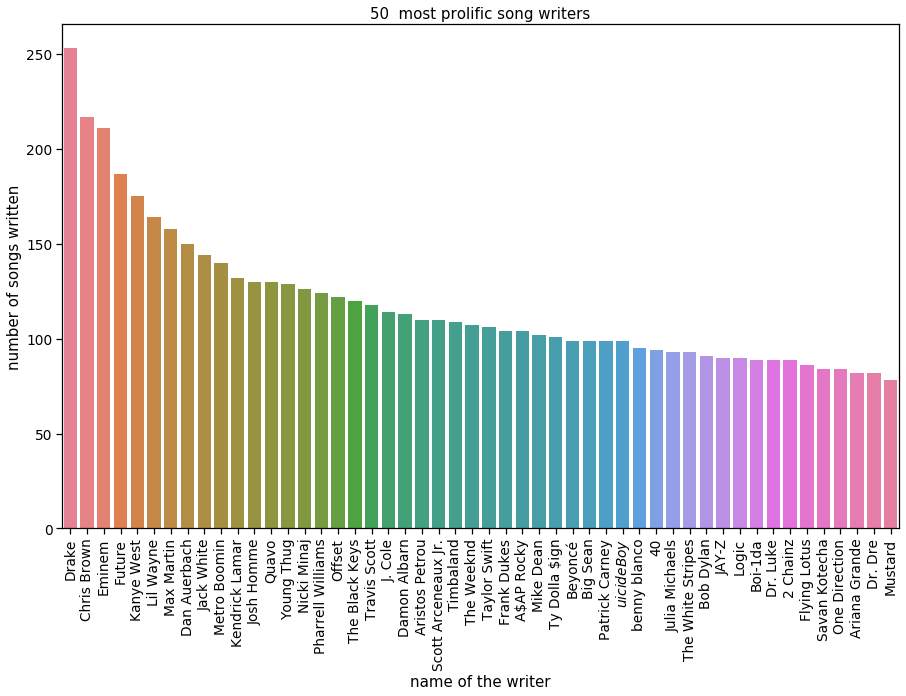

In [323]:
# creation of the list of all the songwriters in our dataframe
songwriters_list = []
for list_ in final_dataframe['songwriters'].values:
    for elem in list_:
        songwriters_list.append(elem)

# now lets count the number of occurences of each songwriter in our dataset
song_writers_dictionnary = dict(collections.Counter(songwriters_list))

# lets plot our data (50 most common)
plot_n_most_common_persons(song_writers_dictionnary, 50, x_lab='name of the writer', y_lab='number of songs written', title=' most prolific song writers')

What we can do now for examples is looking at the songs that a non singer songwriter has written. What song a singer didn't wrote for him and even what successes reach the songs they worked on

In [339]:
def find_songs_for_given_person(df, column_of_interest, name):
    
    '''
    find the songs that a given person helped created
    INPUT: df: dataframe of our cleaned data.
           column_of_interest: the role of the person we are looking for (producer or song_writer)
           name: name of the person we want to obtain informations about
    OUTPUT: list_of_songs:
    '''
    
    list_of_songs = []
    for row in df.iterrows():
        if name in row[1][column_of_interest]:
            to_append = (row[1]['track_name'], row[1]['artist_name'], row[1]['popularity'])
            list_of_songs.append(to_append)
    return list_of_songs

def print_artist_worked_with(list_of_songs, name, plot_artist_himself=True):
    
    '''
    plot all the artist which the person of interest worked with
    INPUT: list_of_songs: The songs on which the producer/writer worked on
           name: the name of the producer/writer
    '''
    dict_artists = {}
    for tup in list_of_songs:
        name_ = tup[1]
        if name_ in dict_artists.keys():
            dict_artists[name_] +=1
        else:
            dict_artists[name_] = 1
    
    if not(plot_artist_himself):        
        del dict_artists[name]
    
    plot_n_most_common_persons(dict_artists, -1, x_lab= 'artists who worked with ' + name, \
                               y_lab='number of songs done together', title= 'number of songs done by artists with ' + name)
    
def print_more_popular_track(list_of_songs, name, n):
    
    '''
    Plot the most popular track (at the time of the pull) that the producer/writer worked on
    INPUT: list_of_songs: The songs on which the producer/writer worked on
           name: the name of the producer/writer
           n: the n most popular track you want to plot
    '''
    dict_popularity = {}
    for tup in list_of_songs:
        name_ = tup[1]
        track = tup[0]
        dict_popularity[track + ' by ' + name_] = tup[2]
        
    plot_n_most_common_persons(dict_popularity, n, x_lab= 'songs on which ' + name + ' worked', \
                               y_lab='popularity of the songs', title= 'more popular tracks from ' + name)
    
def study_actor(df, name, role, n=40,  plot_artist_himself=True):
    
    '''
    Full study of the work of a person place in the industry
    INPUT: df: dataframe of our cleaned data.
           column_of_interest: the role of the person we are looking for (producer or song_writer)
           name: name of the person we want to obtain informations about
    
    '''
    list_of_songs = find_songs_for_given_person(df, role, name)
    print_artist_worked_with(list_of_songs, name, plot_artist_himself= plot_artist_himself)
    print_more_popular_track(list_of_songs, name, n)

Here we are looking at the influence of the songwriters Max Martin on the industry. Has you can see he has worked on really popular tracks (like all the last album of Arianna Grande or the hit I want it that way from the Backstreet Boys).

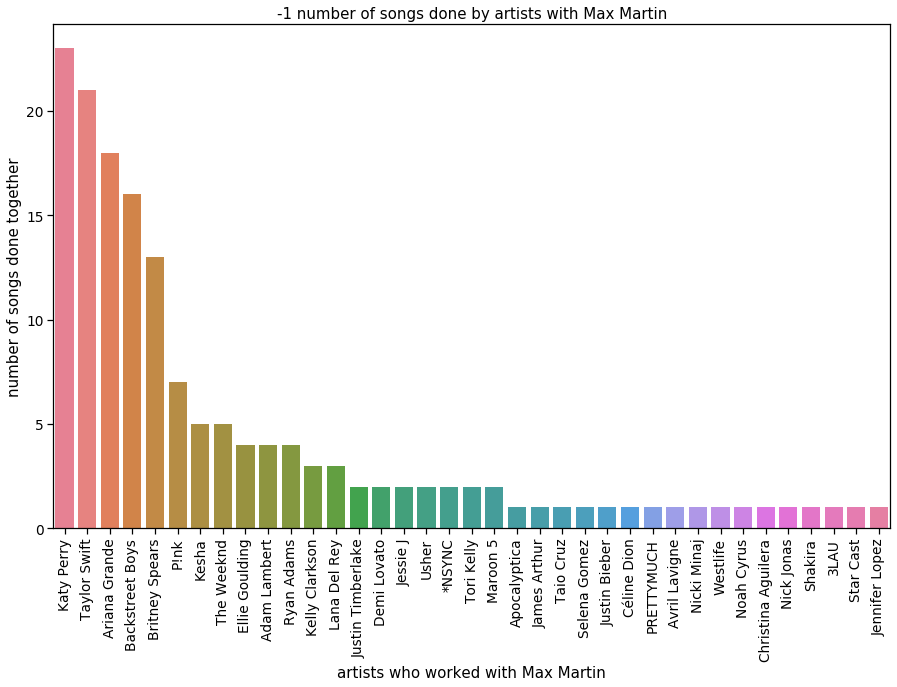

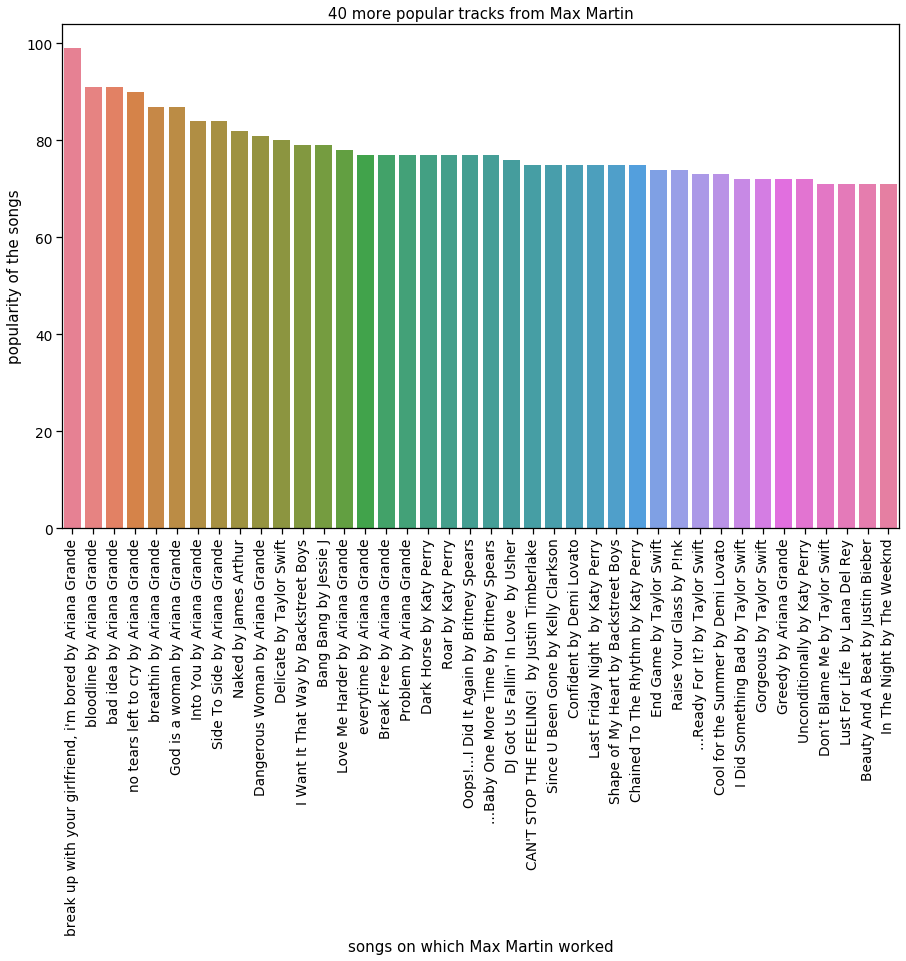

In [338]:
study_actor(final_dataframe, 'Max Martin', 'songwriters')

Now lets look at a well known songwriter as Ed Sheeran and let's study is place in the industry

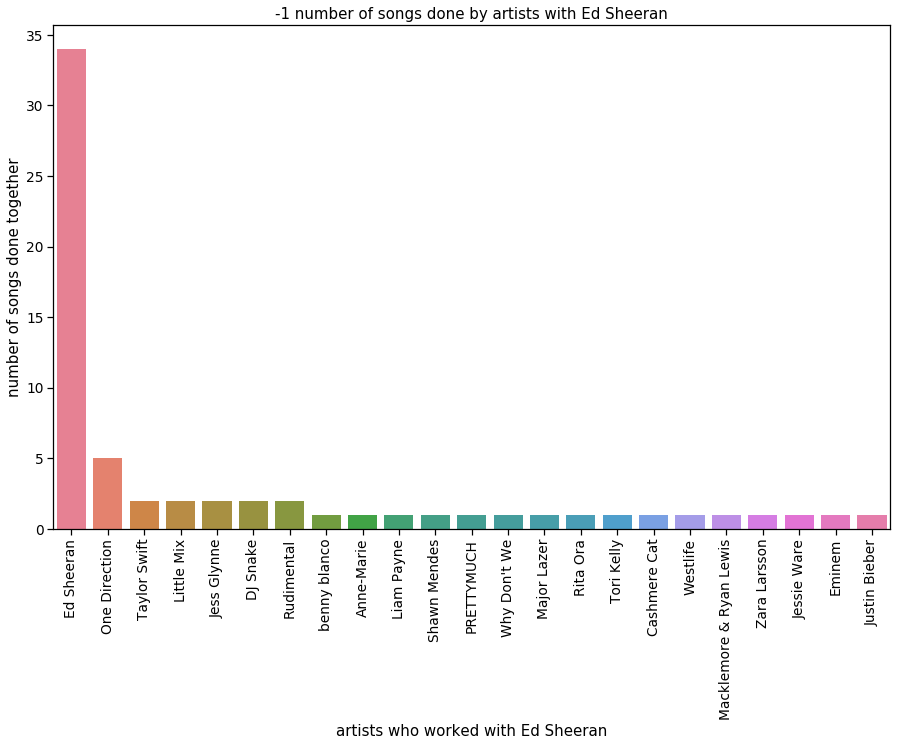

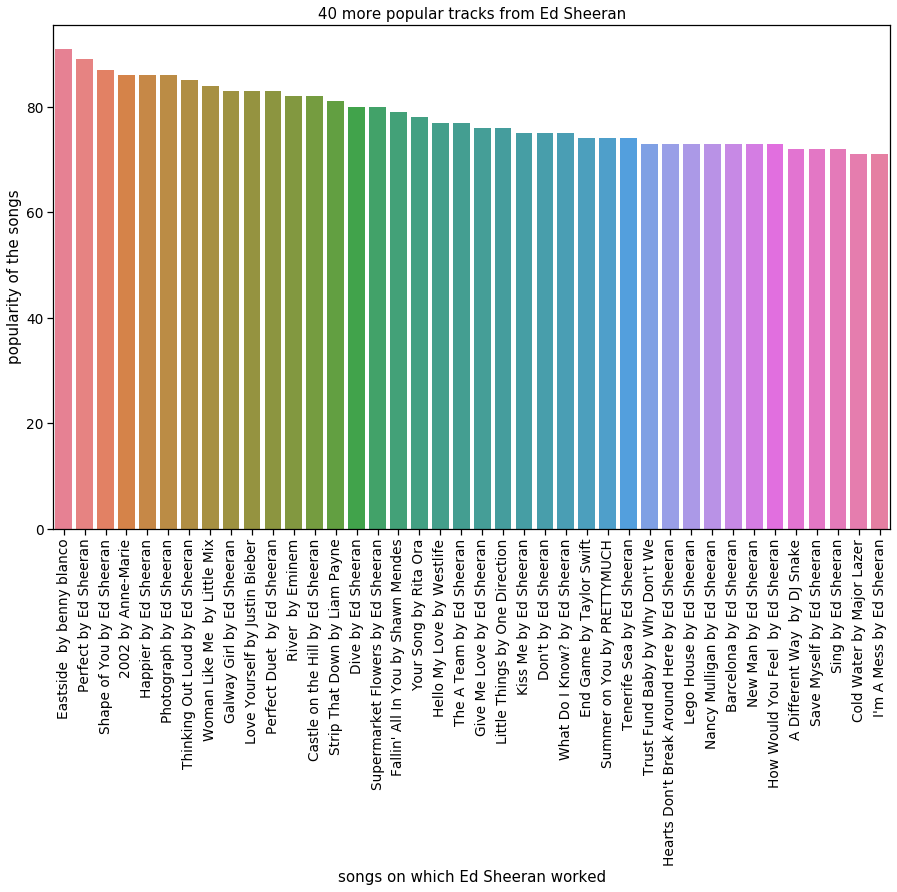

In [340]:
study_actor(final_dataframe, 'Ed Sheeran', 'songwriters')